In [57]:
from enum import Enum
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [59]:
class CNN_TYPE(Enum):
    VGGNET = 1
    GOOGLENET = 2
    RESNET = 3
    MOBILENET = 4

In [60]:
current_cnn_type = CNN_TYPE.MOBILENET

In [61]:
def get_cnn_mode(type, image_shape):
    preprocess_input = []
    abc_model = []
    t2wi_model = []
    if type==CNN_TYPE.VGGNET:
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
        model = tf.keras.applications.VGG16(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
    elif type==CNN_TYPE.GOOGLENET:    
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
        model = tf.keras.applications.InceptionV3(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
    elif type==CNN_TYPE.RESNET:    
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
        model = tf.keras.applications.ResNet50(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
    elif type==CNN_TYPE.MOBILENET:    
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

    else:
        preprocess_input = tf.keras.applications.vgg19.preprocess_input
        model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
    return preprocess_input, model

In [62]:
IMG_SHAPE = (224, 224, 3)
preprocess_input, base_model = get_cnn_mode(current_cnn_type, IMG_SHAPE)

In [178]:
# initialize the initial learning rate, number of epochs to train for, and batch size
LR = 1e-4
EPOCHS = 1
batch_size = 32
InputPath = r"C:\Users\Ali Qaisar\Documents\FaceMask_Dataset"
Clasess = ["WithMask", "WithoutMask"]

In [166]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

images = []
labels = []
for each_cls in Clasess:
    path = os.path.join(InputPath, each_cls)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        images.append(image)
        labels.append(each_cls)

[INFO] loading images...


In [167]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

images = np.array(images, dtype="float32")
labels = np.array(labels)

(X_train, X_test, Y_train, Y_test) = train_test_split(images, labels,test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
data_augumentation = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [168]:

# construct the head of the model that will be placed on top of the
# the base model
model = base_model.output
#model = AveragePooling2D(pool_size=(7, 7))(model)

model=tf.keras.layers.GlobalAveragePooling2D()(model)
model = Flatten(name="flatten")(model)
model = Dense(128, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)

model = Model(inputs=base_model.input, outputs=model)

for layer in base_model.layers:
    layer.trainable = False

In [172]:
# compile our model
opt = Adam(learning_rate=LR, decay=LR / EPOCHS) 
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

A:\Anaconda\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [174]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [180]:
history = model.fit(data_augumentation.flow(X_train, Y_train, batch_size=batch_size),steps_per_epoch=int(len(X_train)/4) 
                    // batch_size,validation_data=(X_test, Y_test),validation_steps=len(X_test) // batch_size, epochs=EPOCHS)


12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8435 - loss: 0.4291 - val_accuracy: 0.9375 - val_loss: 0.3221


In [182]:
import matplotlib.pyplot as plt
def train_histor_view(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label= 'Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(name + ' ' + 'Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(name + ' ' + 'Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

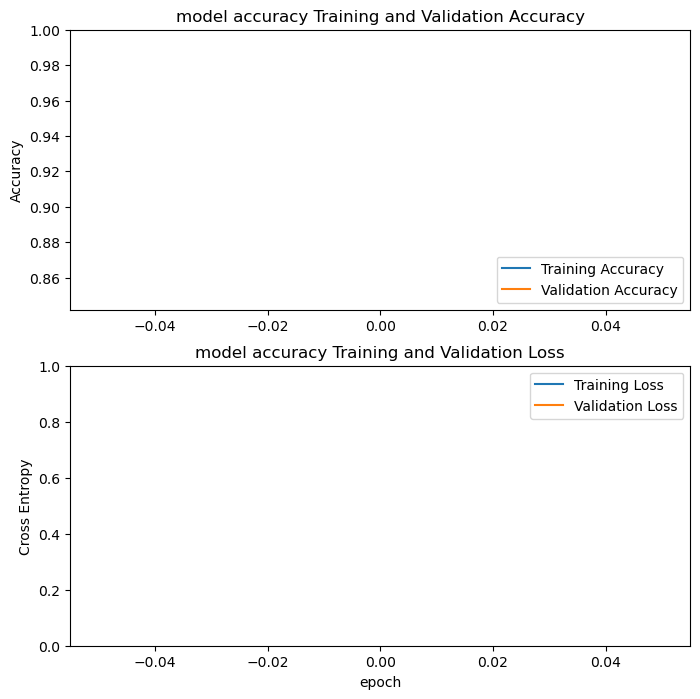

In [184]:
train_histor_view(history, 'model accuracy')

In [186]:
from sklearn.metrics import classification_report

In [188]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(Y_test.argmax(axis=1), predIdxs,target_names=lb.classes_))


[INFO] evaluating network...
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 
              precision    recall  f1-score   support

    WithMask       0.91      0.97      0.94       200
 WithoutMask       0.97      0.91      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



Confusion matrix, without normalization
[[194   6]
 [ 19 181]]


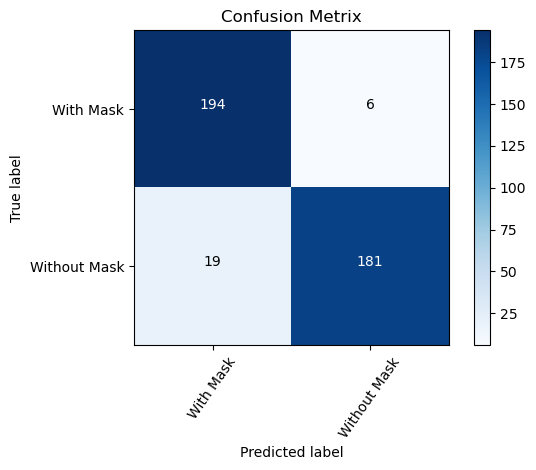

In [189]:

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(Y_test.argmax(axis=1), predIdxs)

cm_plot_label =['With Mask', 'Without Mask']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix')

In [190]:
def calculate_sensitivity_specificity(y_test, y_pred_test):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

In [191]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(Y_test.argmax(axis=1), predIdxs)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.905
Specificity: 0.97
Accuracy: 0.9375


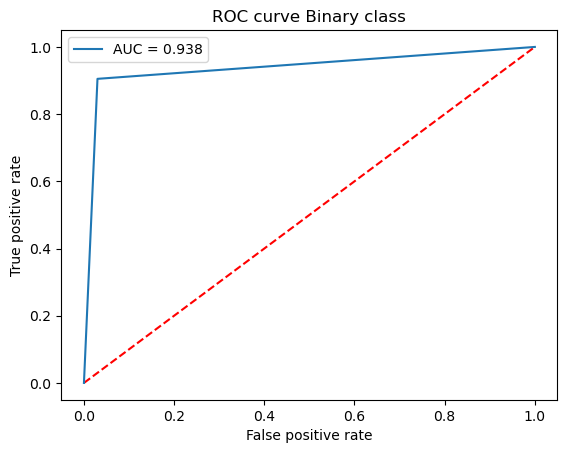

In [196]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(Y_test.argmax(axis=1), predIdxs)
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test.argmax(axis=1), predIdxs)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Binary class')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [198]:
# saving and loading the .h5 model

# save model
model.save('MobileNet.h5')
print('Model Saved!')

Model Saved!


In [200]:
from tensorflow.keras.models import load_model

In [202]:
# load model
savedModel=load_model('MobileNet.h5')
savedModel.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,212 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)